### Collect data out of MongoDB and Chroma DB

In [24]:
import os
import pymongo
import pandas as pd
from dotenv import load_dotenv
# import torch
import chromadb
# from PIL import Image
# from transformers import CLIPProcessor, CLIPModel
import requests
from io import BytesIO
from tqdm import tqdm

load_dotenv()

True

In [50]:
#no user warnins
import warnings
warnings.filterwarnings('ignore')

In [6]:
client = pymongo.MongoClient(os.getenv('MONGO_CONNECTION_STRING'))
db = client["monin"]
collection = db["drinks"]

In [7]:
collection.find({})[0]

{'_id': ObjectId('67cdeca2d61baaa7449cc9f0'),
 'name': 'Hawaiian Pearl Bubble Tea',
 'recipie': ['30 mL Monin Hawaiian Island Syrup',
  '150 mL tea',
  '60 mL club soda',
  '45 mL tapioca bobas',
  'Fill serving glass full of ice.',
  'Pour ingredients into serving glass in order listed.',
  'Stir gently to mix.',
  'Add garnish and serve.'],
 'category': 'bubble_teas',
 'image_url': 'https://monin.blob.core.windows.net/recipe/images/mrd/drink/5125b732-6dea-4287-a76e-fdb0588dc394-2.png',
 'drink_url': 'https://monin.us/products/hawaiian-pearl-bubble-tea',
 'taste': ['Citrusy', 'Sour']}

In [9]:
collection.count_documents({})

2004

In [12]:
chroma_client_remote = chromadb.HttpClient(host=os.environ.get('CHROMA_URL'), port=8000,
                         settings=chromadb.config.Settings(
                            chroma_client_auth_provider="chromadb.auth.token_authn.TokenAuthClientProvider", 
                            chroma_client_auth_credentials=os.environ.get('CHROMA_TOKEN')
                         ))

collection_text = chroma_client_remote.get_or_create_collection(name="drinks_text")
collection_image = chroma_client_remote.get_or_create_collection(name="drinks_image")
collection_combined = chroma_client_remote.get_or_create_collection(name="drinks_combined")

local_text_data = collection_text.get(include=["embeddings", "uris", "documents", "metadatas"])
local_image_data = collection_image.get(include=["embeddings", "uris", "documents", "metadatas"])
local_combined_data = collection_combined.get(include=["embeddings", "uris", "documents", "metadatas"])



In [20]:
print(len(local_text_data['ids']))

2004
2004


In [22]:
# output few records
print(local_image_data)

{'ids': ['67cdeca2d61baaa7449cc9f0', '67cdeca4d61baaa7449cc9f1', '67cdeca6d61baaa7449cc9f2', '67cdeca8d61baaa7449cc9f3', '67cdecabd61baaa7449cc9f4', '67cdecadd61baaa7449cc9f5', '67cdecafd61baaa7449cc9f6', '67cdecb1d61baaa7449cc9f7', '67cdecb4d61baaa7449cc9f8', '67cdecb6d61baaa7449cc9f9', '67cdecb8d61baaa7449cc9fa', '67cdecbad61baaa7449cc9fb', '67cdecbcd61baaa7449cc9fc', '67cdecbed61baaa7449cc9fd', '67cdecc0d61baaa7449cc9fe', '67cdecc2d61baaa7449cc9ff', '67cdecc5d61baaa7449cca00', '67cdecc6d61baaa7449cca01', '67cdecc9d61baaa7449cca02', '67cdeccbd61baaa7449cca03', '67cdeccdd61baaa7449cca04', '67cdeccfd61baaa7449cca05', '67cdecd3d61baaa7449cca06', '67cdecd5d61baaa7449cca07', '67cdecd7d61baaa7449cca08', '67cdecd9d61baaa7449cca09', '67cdecdbd61baaa7449cca0a', '67cdecddd61baaa7449cca0b', '67cdecdfd61baaa7449cca0c', '67cdece1d61baaa7449cca0d', '67cdece3d61baaa7449cca0e', '67cdece5d61baaa7449cca0f', '67cdece7d61baaa7449cca10', '67cdece9d61baaa7449cca11', '67cdecebd61baaa7449cca12', '67cdecedd6

In [25]:
data = list(collection.find({}))
df = pd.DataFrame(data)

# If available, load your embeddings from chromadb (assuming they match the same order as your df)
# For example, after retrieving the embeddings:
df['text_embeds'] = list(local_text_data['embeddings'])
df['image_embeds'] = list(local_image_data['embeddings'])

In [28]:
df['combined_embeds'] = list(local_combined_data['embeddings'])

In [29]:
df.head()

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
0,67cdeca2d61baaa7449cc9f0,Hawaiian Pearl Bubble Tea,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/hawaiian-pearl-bubbl...,"[Citrusy, Sour]","[-0.2425253838300705, -0.03239031136035919, -0...","[-0.271756649017334, 0.7865740656852722, -0.12...","[-0.2425253838300705, -0.03239031136035919, -0..."
1,67cdeca4d61baaa7449cc9f1,Blue Bubble Milk Tea,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blue-bubble-milk-tea,"[Floral, Salty, Sweet]","[-0.1409539431333542, -0.08377346396446228, 0....","[0.13253293931484222, 0.3377094864845276, -0.1...","[-0.1409539431333542, -0.08377346396446228, 0...."
2,67cdeca6d61baaa7449cc9f2,Strawberry Bubble Burst Tea,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/strawberry-bubble-bu...,"[Fruity, Floral, Sweet, Bitter]","[-0.15835341811180115, 0.0019426532089710236, ...","[-0.25111329555511475, 0.8149627447128296, -0....","[-0.15835341811180115, 0.0019426532089710236, ..."
3,67cdeca8d61baaa7449cc9f3,Bubble Chai Tea,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/bubble-chai-tea,"[Sweet, Creamy]","[-0.129270538687706, -0.0847550630569458, 0.08...","[0.051974114030599594, 0.3284218907356262, -0....","[-0.129270538687706, -0.0847550630569458, 0.08..."
4,67cdecabd61baaa7449cc9f4,Golden Jelly Bubble Tea,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/golden-jelly-bubble-tea,"[Floral, Salty, Bitter, Floral]","[-0.2102978527545929, -0.07430075109004974, 0....","[-0.3368239104747772, 0.9911291599273682, -0.2...","[-0.2102978527545929, -0.07430075109004974, 0...."


### Initial exploration

In [30]:
df_exploded = df.explode('taste')
df_exploded['taste'].value_counts()

taste
Sweet         1420
Sour          1337
Floral        1278
Citrusy        650
Spicy          592
Umami          492
Tart           433
Bitter         387
Fruity         383
Creamy         349
Salty          278
Herbal         204
Rich           124
Milky           15
Light           12
Refreshing      10
Earthy           6
Name: count, dtype: int64

### EDA

#### Class & Flavor Distribution

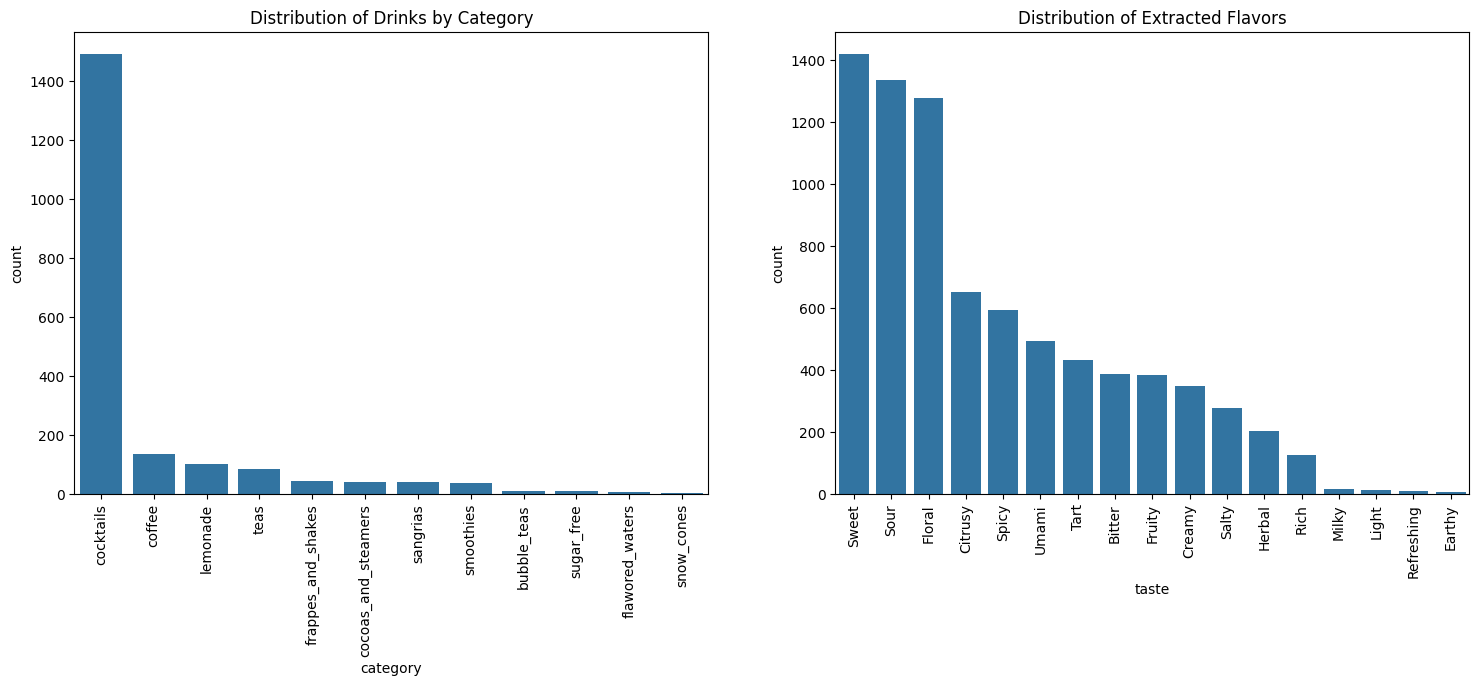

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(data=df, x='category', order=df['category'].value_counts().index, ax=axs[0])
axs[0].set_title('Distribution of Drinks by Category')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# plot flavor distribution
sns.countplot(data=df_exploded, x='taste', order=df_exploded['taste'].value_counts().index, ax=axs[1])
axs[1].set_title('Distribution of Extracted Flavors')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()


The category distribution is skewed, with 'cocktails' being much more represented than other categories. The flavor distribution is also skewed, with 'Sweet', 'Sour', and 'FLoral' being the most common flavors, although not as skewed as the category distribution.

#### Category vs. Flavor

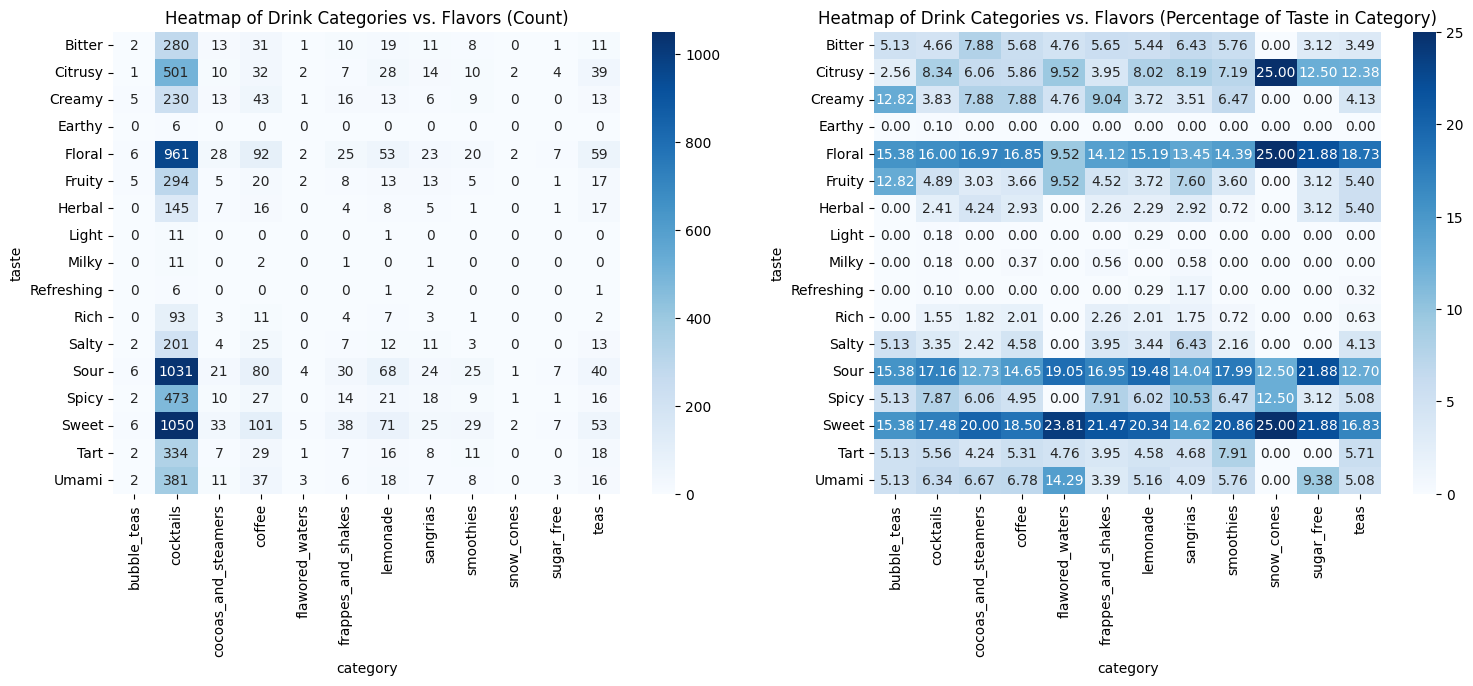

In [61]:
pivot = df_exploded.pivot_table(index='taste', columns='category', aggfunc='size', fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=0), axis=1) * 100

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Heatmap of Drink Categories vs. Flavors (Count)')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

sns.heatmap(pivot_percentage, annot=True, fmt='.2f', cmap='Blues', ax=axs[1])
axs[1].set_title('Heatmap of Drink Categories vs. Flavors (Percentage of Taste in Category)')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()


We can see, that some flavors are being picked for all categories more often, such as 'Sweet', 'Sour', 'Floral', while some are continuosely being choosed less often, such as 'Light', 'Milky' and 'Refreshing'. We can also notice, that some categories have a flavor that is being picked more often than in other categories, such as 'Sour' in 'sugar free' category, 'Sweet', 'Floral' and 'Citrusy' for 'snow_cones', and 'Creamy' for 'bubble_teas'.

#### Distribution of quantity of extracted flavors

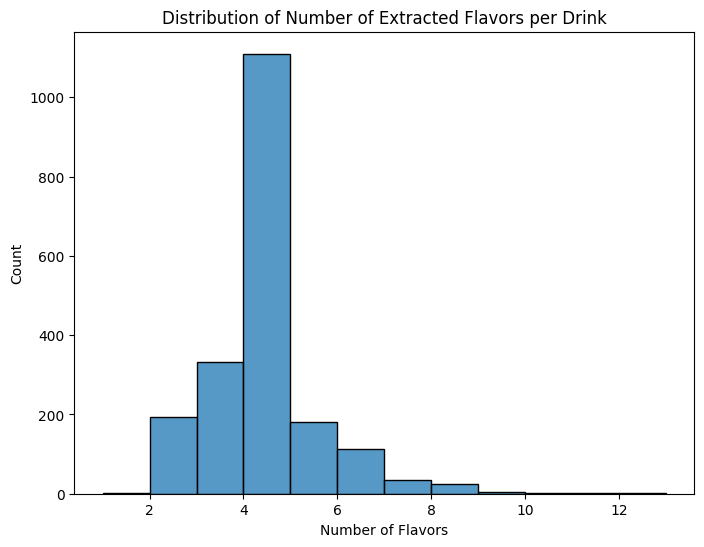

In [62]:
# Calculate number of flavors per drink
df['num_tastes'] = df['taste'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(8, 6))
sns.histplot(df['num_tastes'], bins=range(1, df['num_tastes'].max()+2), kde=False)
plt.title('Distribution of Number of Extracted Flavors per Drink')
plt.xlabel('Number of Flavors')
plt.ylabel('Count')
plt.show()


The distribution seems to be close to normal, with most drinks having around 4-5 flavors extracted.

#### t-SNE Visualization of Embeddings

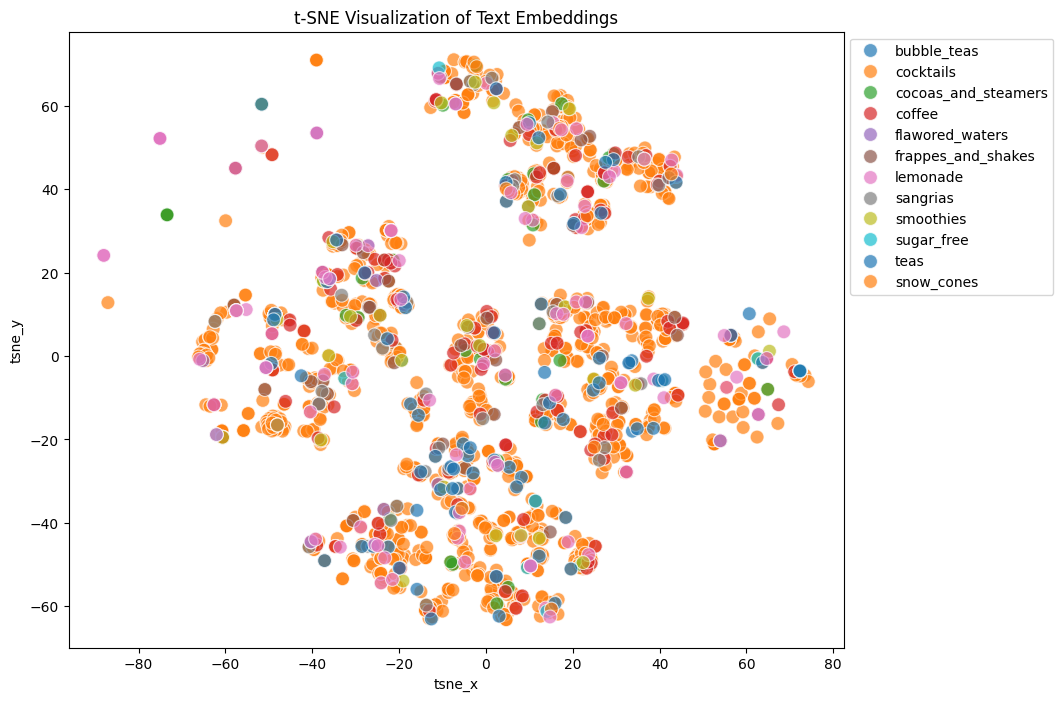

In [63]:
from sklearn.manifold import TSNE
import numpy as np

# Convert embedding list to array
embeds = np.array(list(df['text_embeds']))  # or use 'combined_embeds' if you concatenated

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab10", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Text Embeddings')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


Text embeddings seem to have some clusters, although they do not correlate with category. This may indicate that ingredients and process of preparation may be the same for different categories, and it is important to investigate these clusters further.

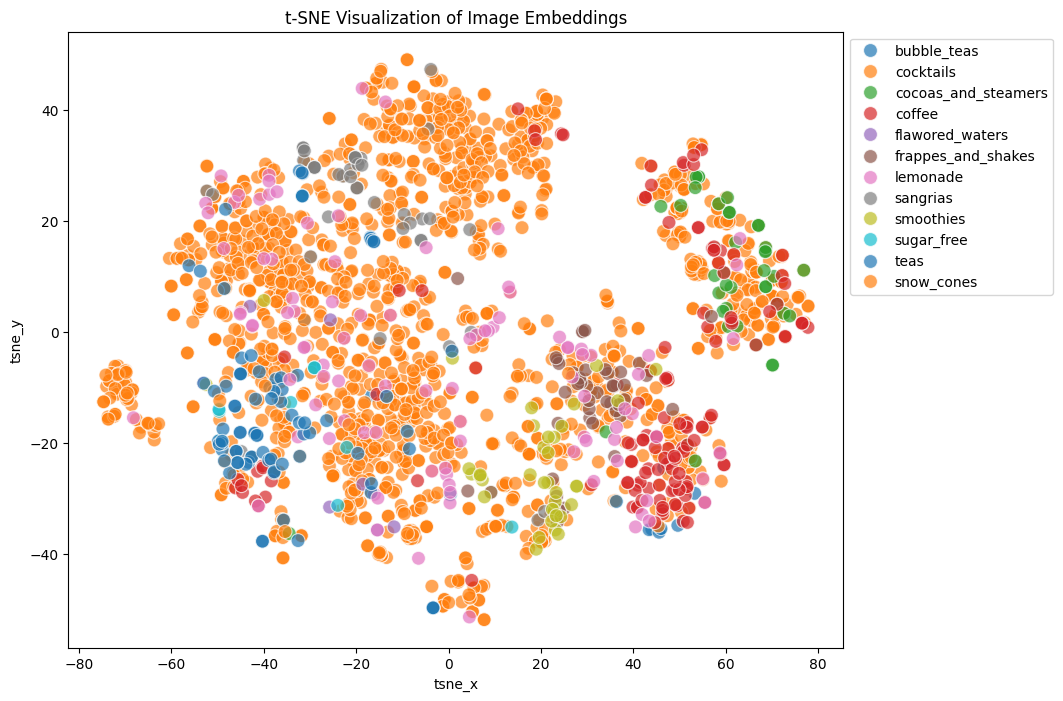

In [64]:
# now the same for image embeddings and combined embeddings
# Convert embedding list to array
embeds = np.array(list(df['image_embeds']))  # or use 'combined_embeds' if you concatenated

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab10", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Image Embeddings')

plt.legend(bbox_to_anchor=(1, 1))
plt.show()


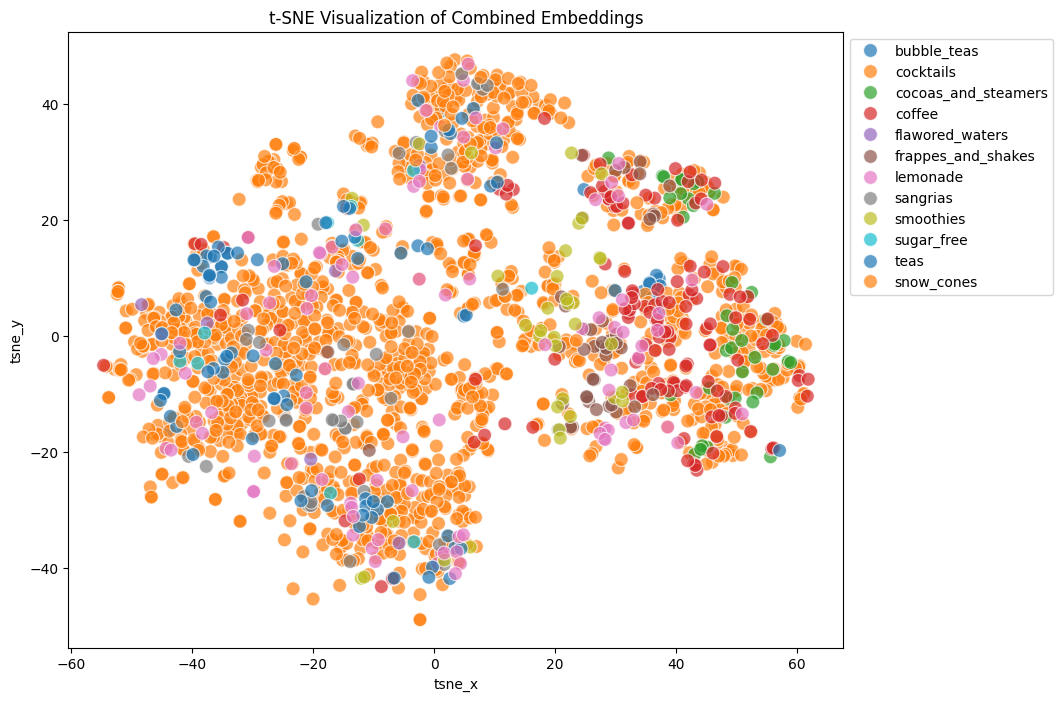

In [65]:
# Convert embedding list to array
embeds = np.array(list(df['combined_embeds']))  # or use 'combined_embeds' if

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab10", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Combined Embeddings')

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

The clusters of image and common embeddings seem to be even more broad and not correlating with the category. This may indicate that the images and text are not very informative for analysing the taste of the drink. 
But, interestingly, some categories have a clear cluster, such as 'coffe', 'smoothies' and 'bubble teas'. This may indicate that these categories have a clear visual representation that is different from other categories.

#### Analyzing ingredients and recipes

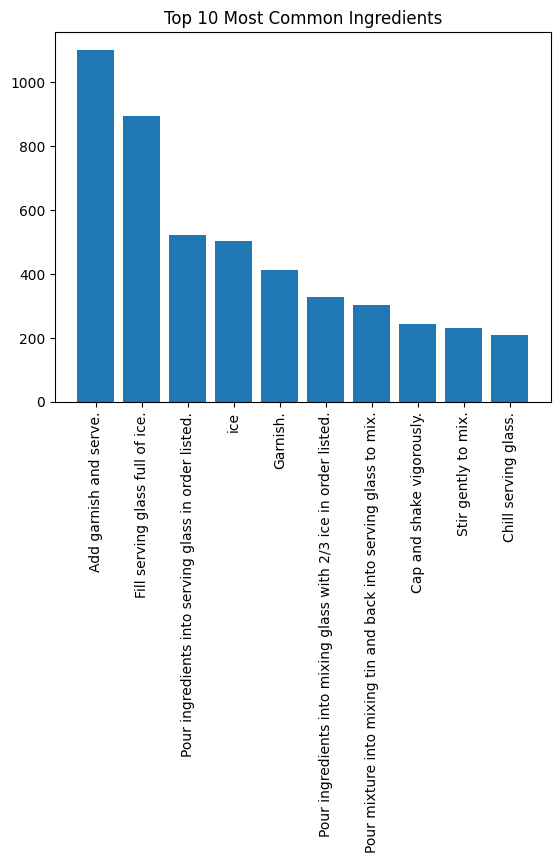

In [67]:
from collections import Counter

# Assume each recipe's ingredients are stored as a list in the 'recipie' column
all_ingredients = [item for sublist in df['recipie'] for item in sublist]
ingredient_counts = Counter(all_ingredients)

# Visualize with a bar chart or word cloud
import matplotlib.pyplot as plt
most_common = ingredient_counts.most_common(10)
ingredients, counts = zip(*most_common)
plt.bar(ingredients, counts)
plt.xticks(rotation=90)
plt.title('Top 10 Most Common Sentences in the recipes')
plt.show()
